# Staging Drosophila Embryos
The objective of the project is to develop a model that would predict the stage of the development of a Drosophila embryo based on the image of the embryo. The final model would take as input an image of the the embryos stained for DAPI and output the development time.

## Colab-related imports

In [ ]:
# import data into google colab
from google.colab import files
import io
uploaded = files.upload()

Saving CrossSections.zip to CrossSections.zip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip data
import zipfile
zf = zipfile.ZipFile(io.BytesIO(uploaded['CrossSections.zip']), "r")
zf.extractall('CrossSections')

## Specifications
This section specifies libraries to import, folder locations and filenames

### Specify libraries to import

In [1]:
# Standard import statements
#
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard

In [13]:
# Import local modules
#
from data import Data
from tfimage import TFImage
from cvimage import CVImage, NuclearLayer

### Specify paths

In [7]:
#
# Folder specifications
#
sys_folder  = '/Volumes/X2/Projects/staging/Data/'
data_folder = sys_folder + 'data/'


## Data preparation

 This section is for data preparation. It reads the csv files and creates a dataset each for training and validation. Images are then read from the disk, reshaped and augmented.

### Functions

In [ ]:
# Functions for reading images, reshaping and augmenting. Followed by wrapper functions functions
#
def read_image(image_file, label):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_image(image,channels=3, dtype=tf.float32)
    return image, label

def reshape_image(image,label):
    global target_dim
    H = tf.shape(image)[0]      # This is very important. Dataset fails otherwise.
    W = tf.shape(image)[1]
    i0 = rng.uniform(shape=[1],minval=0, maxval=H-target_dim,dtype = tf.dtypes.int32)[0]
    #i0 = np.random.randint(0,image.shape[0]-target_dim)
    irand = rng.uniform(shape=[1])[0]
    if irand<0.25:
        image = image[i0:i0+target_dim,0:target_dim,:]
    elif irand>=0.25 and irand<0.5:
        image = image[i0:i0+target_dim,H-target_dim:H,:]
    elif irand>=0.5 and irand<0.75:
        image = image[0:target_dim,i0:i0+target_dim,:]
    elif irand>=0.75:
        image = image[W-target_dim:W,i0:i0+target_dim,:]
    #image = tf.image.per_image_standardization(image)
    #image = tf.linalg.normalize(image,axis=2)
    #image = image[0]
    #image = (image - min(image))/(max(image)-min(image))
    return image, label

def augment(image,label,seed):
    image = tf.image.stateless_random_flip_left_right(image,seed=seed)
    image = tf.image.stateless_random_flip_up_down(image,seed=seed)
    image = tf.image.stateless_random_brightness(image, max_delta = 0.5, seed = seed)
    image = tf.image.stateless_random_contrast(image,lower = 0.5,upper = 1.5,seed = seed)
    return image,label

def normalize_image(image,label):
    imin = tf.math.reduce_min(image)
    imax = tf.math.reduce_max(image)
    image = (image - imin)/(imax - imin)
    return image,label

def readImagewBoundary(image_file, label,xL,yL):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_image(image,channels=3, dtype=tf.float32)
    return image, label, xL, yL

def reshapeImagewBoundary(image,label,xL,yL):
    global target_dim
    i0    = rng.uniform(shape=[1],minval=0, maxval=xL.shape[0],dtype = tf.dtypes.int32)[0]
    image = image[yL[i0]:yL[i0]+target_dim,xL[i0]:xL[i0]+target_dim,:]
    print(image.shape)
    return image,label



In [ ]:
# wrapper functions for training and
#
def wrapper_train(image_file,label):
    image,label  = read_image(image_file,label)
    image,label  = reshape_image(image,label)
    seed         = rng.make_seeds(2)[0]
    image, label = augment(image,label,seed)
    image, label = normalize_image(image,label)
    return image,label

def wrapper_val(image_file,label):
    image,label  = read_image(image_file,label)
    image,label  = reshape_image(image,label)
    image, label = normalize_image(image,label)
    return image,label

def wrapper_train_boundary(image_file,label,xL,yL):
    image,label,xL,yL = readImagewBoundary(image_file,label,xL,yL)
    image,label       = reshapeImagewBoundary(image,label,xL,yL)
    seed              = rng.make_seeds(2)[0]
    image, label      = augment(image,label,seed)
    image, label      = normalize_image(image,label)
    return image,label

def wrapper_val_boundary(image_file,label,xL,yL):
    image,label,xL,yL = readImagewBoundary(image_file,label,xL,yL)
    image,label       = reshapeImagewBoundary(image,label,xL,yL)
    image,label       = normalize_image(image,label)
    return image,label

### Make dataset and print sample images

In [ ]:
# Setup datasets
#
# Make training and validation dataframes
def makeTFdatasetwBoundary(csvfile, xLfile, yLfile):
    df         = pd.read_csv(csvfile)
    filenames  = img_folder + df["filenames"].values
    id         = df["id"].values
    df         = pd.read_csv(xLfile,header=None)
    xL         = np.array(df,dtype=np.int32)
    df         = pd.read_csv(yLfile,header=None)
    yL         = np.array(df,dtype=np.int32)
    return tf.data.Dataset.from_tensor_slices((filenames, id, xL, yL))

def makeTFdataset(csvfile):
    df         = pd.read_csv(csvfile)
    filenames  = img_folder + df["filenames"].values
    id         = df["id"].values
    df         = tf.data.Dataset.from_tensor_slices((filenames, id))
    return tf.data.Dataset.from_tensor_slices((filenames, id))

ds_train = makeTFdatasetwBoundary(train_csv, xL_train, yL_train)
ds_val   = makeTFdatasetwBoundary(val_csv, xL_val, yL_val)
ds_test  = makeTFdatasetwBoundary(test_csv, xL_test, yL_test)

def configure_for_performance(ds,nBatch):
    ds = ds.cache()
    ds = ds.batch(nBatch)
    ds = ds.shuffle(buffer_size=shufflenum)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

#ds_train = ds_train.map(wrapper_train_boundary, num_parallel_calls=AUTOTUNE)
#ds_val   = ds_val.map(wrapper_val_boundary, num_parallel_calls=AUTOTUNE)

ds_train = configure_for_performance(ds_train.map(wrapper_train_boundary, num_parallel_calls=AUTOTUNE),nBatchTrain)
ds_val   = configure_for_performance(ds_val.map(wrapper_val_boundary, num_parallel_calls=AUTOTUNE),nBatchVal)

#ds_train = ds_train.batch(nBatchTrain).map(read_image,num_parallel_calls=AUTOTUNE).map(wrapper_train,num_parallel_calls=AUTOTUNE).cache().shuffle(shufflenum,reshuffle_each_iteration=True).prefetch(AUTOTUNE)
#ds_val   = ds_val.map(read_image,num_parallel_calls=AUTOTUNE).batch(nBatchVal).map(wrapper_val,num_parallel_calls=AUTOTUNE).cache().shuffle(shufflenum,reshuffle_each_iteration=True).prefetch(AUTOTUNE)

<unknown>
<unknown>


1.0
0.0
(50, 50, 3)


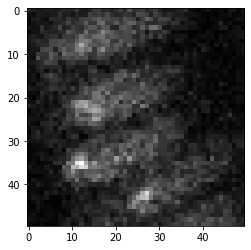

In [ ]:
images, labels = next(iter(ds_train))

image = images[3].numpy()
plt.imshow(image,cmap='gray')
image = np.asarray(image)
print(image.max())
print(image.min())
print(image.shape)


## Model definition

 This section defines the model. The model maybe be custom-defined or a pre-trained model can be used.


### Using a pre-trained model

#### Load model and freeze layers

##### MobileNetV2

In [ ]:
# load the pre-trained model
#
IMG_SHAPE = [target_dim,target_dim,3]
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
# check base model
#
image_batch, label_batch = next(iter(ds_train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False
inputs = tf.keras.Input(shape=(target_dim,target_dim,3))
x      = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
#base_model.summary()

(25, 3, 3, 1280)


##### ResNet50V2

In [ ]:
# load model
#
IMG_SHAPE = [target_dim,target_dim,3]
base_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

In [ ]:
# check base model
#
image_batch, label_batch = next(iter(ds_train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False
inputs = tf.keras.Input(shape=(target_dim,target_dim,3))
x      = tf.keras.applications.resnet_v2.preprocess_input(inputs)
#base_model.summary()

(25, 3, 3, 2048)


##### Inception V3

In [ ]:
# load model
#
IMG_SHAPE = [target_dim,target_dim,3]
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

ValueError: ignored

In [ ]:
# check base model
#
image_batch, label_batch = next(iter(ds_train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False
inputs = tf.keras.Input(shape=(target_dim,target_dim,3))
#x      = tf.keras.applications.inception_v3.preprocess_input(inputs)
#base_model.summary()

(25, 1, 1, 2048)


##### EfficientNet B7

In [ ]:
# load model
#
IMG_SHAPE = [target_dim,target_dim,3]
base_model = tf.keras.applications.EfficientNetB7(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

In [ ]:
# check base model
#
image_batch, label_batch = next(iter(ds_train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False
inputs = tf.keras.Input(shape=(target_dim,target_dim,3))
#x      = tf.keras.applications.efficientnet.preprocess_input(inputs)
#base_model.summary()

(25, 2, 2, 2560)


##### EfficientNet V2S

In [ ]:
# load model
#
IMG_SHAPE = [target_dim,target_dim,3]
base_model = tf.keras.applications.EfficientNetV2S(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

In [ ]:
# check base model
#
image_batch, label_batch = next(iter(ds_train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False
inputs = tf.keras.Input(shape=(target_dim,target_dim,3))
#x      = tf.keras.applications.efficientnet_v2.preprocess_input(inputs)
#base_model.summary()

(50, 3, 3, 1280)


#### Add additional layers to the model

In [ ]:
# Add additional layers to the model
#
x = base_model(inputs,training=False)       # because of the batchnorm layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs, x)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 efficientnetb7 (Functional)  (None, 2, 2, 2560)       64097687  
                                                                 
 global_average_pooling2d_4   (None, 2560)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_43 (Dense)            (None, 128)               327808    
                                                                 
 dropout_39 (Dropout)        (None, 128)               0         
                                                                 
 dense_44 (Dense)            (None, 128)               16512     
                                                           


### Custom model

 This section defines a custom model created from scratch.

In [ ]:
# Custom model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(250, (2,2),activation='relu', input_shape=(target_dim,target_dim,3)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(250, (2,2),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Conv2D(250, (2,2),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Conv2D(250, (2,2),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Conv2D(250, (2,2),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.MaxPooling2D(2,2),


    tf.keras.layers.Conv2D(250, (2,2),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Conv2D(250, (2,2),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Conv2D(250, (2,2),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(250, (2,2),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Conv2D(250, (2,2),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Conv2D(250, (2,2),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.MaxPooling2D(2,2),


    # Flatten
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.20),

    # Output
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 74, 74, 250)       3250      
                                                                 
 batch_normalization_11 (Bat  (None, 74, 74, 250)      1000      
 chNormalization)                                                
                                                                 
 conv2d_12 (Conv2D)          (None, 73, 73, 250)       250250    
                                                                 
 batch_normalization_12 (Bat  (None, 73, 73, 250)      1000      
 chNormalization)                                                
                                                                 
 dropout_13 (Dropout)        (None, 73, 73, 250)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 250)      

### Load previously-trained model
This section will load a previously trained model to re-train!

In [ ]:
#model_path = './Models/NLBits3_C1'
model = tf.keras.models.load_model(model_path)

## Compile and train


In [ ]:
# compile model
#
model.compile(loss='mean_squared_error', optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), metrics = ['mse'])

In [ ]:
# add checkpoints
#
cp_callback  = tf.keras.callbacks.ModelCheckpoint(model_path,
                                                  verbose = 2,
                                                  save_best_only = True,
                                                  save_freq = 'epoch')
log_callback = TensorBoard(log_dir=log_path, histogram_freq=5)
callbacks    = [cp_callback, log_callback]

In [ ]:
# Training
#
history = model.fit(ds_train, validation_data=ds_val,verbose=2, epochs=500,callbacks=[cp_callback])

Epoch 1/500

Epoch 1: val_loss improved from inf to 0.08046, saving model to /content/drive/MyDrive/Colab Project/Models/CrossSections_C3
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Project/Models/CrossSections_C3/assets
69/69 - 267s - loss: 0.0878 - mse: 0.0878 - val_loss: 0.0805 - val_mse: 0.0805 - 267s/epoch - 4s/step
Epoch 2/500

Epoch 2: val_loss improved from 0.08046 to 0.08005, saving model to /content/drive/MyDrive/Colab Project/Models/CrossSections_C3
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Project/Models/CrossSections_C3/assets
69/69 - 242s - loss: 0.0885 - mse: 0.0885 - val_loss: 0.0801 - val_mse: 0.0801 - 242s/epoch - 4s/step
Epoch 3/500

Epoch 3: val_loss did not improve from 0.08005
69/69 - 11s - loss: 0.0873 - mse: 0.0873 - val_loss: 0.0806 - val_mse: 0.0806 - 11s/epoch - 156ms/step
Epoch 4/500

Epoch 4: val_loss did not improve from 0.08005
69/69 - 10s - loss: 0.0872 - mse: 0.0872 - val_loss: 0.0818 - val_mse: 0.0818 - 10s/epo

## Testing.
This section will load ds_test and test the model on the holdout dataset.

### Evaluate and predict

In [ ]:
# Evaluate model on test data ot get loss and accuracy
#
neval = 10
loss  = np.zeros(neval,1)
acc   = np.zeros(neval,1)
for i in range(neval):
    loss[i], acc[i] = model.evaluate(ds_test, verbose=2)

lossavg = np.mean(loss)
accavg  = np.mean(acc)

In [ ]:
# make predictions using this model
#
neval = 10
y_test_pred = []
for i in range(neval):
    y_test_pred = [y_test_pred,model.predict(ds_test, verbose=2)]

y_test_pred     = np.array(y_test_pred)
y_test_pred_avg = np.mean(y_test_pred,axis=0)

### Plotting

In [ ]:
# prepare for making plots
#
y_test  = list(ds_test.as_numpy_iterator())
y_test  = np.array([i[1] for i in y_test])

i0      = np.argwhere(y_test==1)
i0      = [i[0]+1 for i in i0]
y_test  = np.split(y_test,i0)
y_test_pred_avg = np.split(y_test_pred_avg,i0)
y_test  = y_test[:-1]
y_test_pred_avg = y_test_pred_avg[:-1]

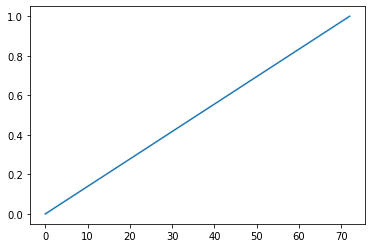

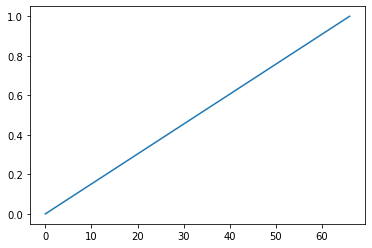

In [ ]:
# run loop through all data points and make plots
#
for i in range(len(y_test)):
    plt.figure(i)
    plt.plot(y_test[i],label='y_test')
    plt.plot(y_test_pred_avg[i],label='predicted')
    plt.legend(['Actual','Predicted'])
    #plt.title(checkpoint_path + img_folder)
    plt.ylim((0,1))

## Layer outputs
Visualize the output of every layer of the model

In [ ]:
#
# Visualize the output of every layer of the model
#
layer_names = [layer.name for layer in model.layers]
layer_outputs = [layer.output for layer in model.layers]

print(layer_names)

['conv2d_10', 'batch_normalization_10', 'conv2d_11', 'batch_normalization_11', 'conv2d_12', 'batch_normalization_12', 'conv2d_13', 'batch_normalization_13', 'max_pooling2d_2', 'conv2d_14', 'batch_normalization_14', 'conv2d_15', 'batch_normalization_15', 'conv2d_16', 'batch_normalization_16', 'dropout_4', 'max_pooling2d_3', 'conv2d_17', 'batch_normalization_17', 'conv2d_18', 'batch_normalization_18', 'conv2d_19', 'batch_normalization_19', 'dropout_5', 'flatten_1', 'dense_4', 'dense_5', 'dropout_6', 'dense_6', 'dropout_7', 'dense_7']


In [ ]:
lnames = [i for i in layer_names if 'conv' in i or 'pool' in i]

In [ ]:
#
# Build a new model with the same input as the original model
#
activation_model = tf.keras.models.Model(model.inputs, layer_outputs)

In [ ]:
#
# get a sample image and feed it to the newly created model
#
[image,label] = wrapper_train(filenames[10], id[10])
features = activation_model(image)

In [ ]:
#
# Print out the results of the model
#
print(features.shape)
plt.imshow(features[0,:,:,:])
